# 2.2 Pipeline 

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

## Using Convo Neural Network with CrossEntropyLoss

### Optimzer using SGD

In [2]:
import torch.nn.functional as F
import torch.optim as optim

class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.convolutaional_neural_network_layers = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # For grayscale input images
                nn.ReLU(), # Activation function after the first convolutional layer
                nn.MaxPool2d(kernel_size=2), # Reduces spatial dimensions
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1), # Second convolutional layer
                nn.ReLU(), # Activation function after the second convolutional layer
                nn.MaxPool2d(kernel_size=2)  # Further reduces spatial dimensions
        )
        self.linear_layers  = nn.Sequential(
                nn.Linear(in_features=24*7*7, out_features=64), # Fully connected layer          
                nn.ReLU(),
                nn.Dropout(p=0.1), # Dropout to prevent overfitting
                nn.Linear(in_features=64, out_features=10) # Final output layer
        )

    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x) # Pass through convolutional layers
        x = x.view(x.size(0), -1) # Flatten the output for the dense layers
        x = self.linear_layers (x) # Pass through dense layers
        x = F.log_softmax(x, dim=1) # Apply log softmax on the final output
        return x
        
net = Network()
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 2.3 Batching JPEG Data to feed into the Model 


2 Folders consisting of Train and Test Data. 

In each folder, there are sub folders that are the labels, with the Handrawn image contained inside. 

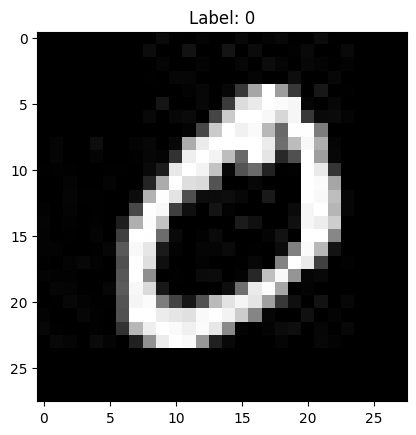

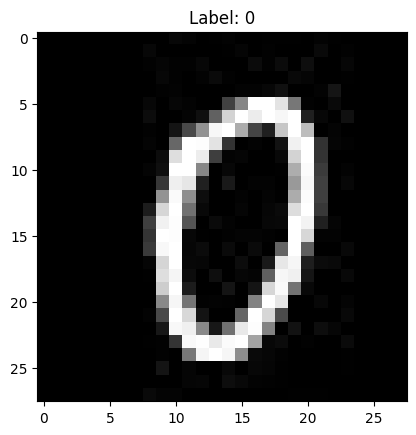

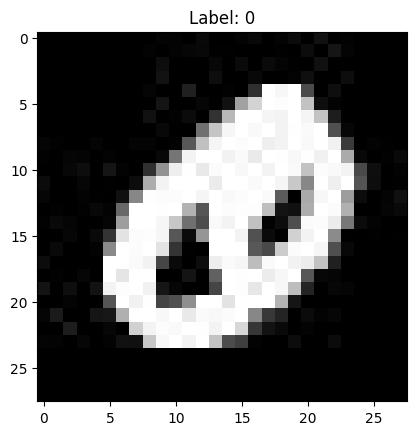

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import glob

test_directory = "MNIST Dataset JPG format\\MNIST - JPG - testing"
training_directory = "MNIST Dataset JPG format\\MNIST - JPG - training"

class CustomDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in range(10):  
            subfolder = os.path.join(directory, str(label))
            for image_path in glob.glob(os.path.join(subfolder, '*.jpg')):
                self.image_paths.append(image_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Start with a Transformation such that the image can be fitted into the mdoel 
transform = transforms.Compose([
    transforms.Grayscale(),  # grayscale image 
    transforms.Resize((28, 28)),  # Resize just in case 
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

# Instantiate dataset for Testing of DataLoader and Labelling 
test_dataset = CustomDataset(training_directory, transform=transform)

# show image
def show_image(img, label):
    img = img.numpy().squeeze()
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {label}")
    plt.show()

# Test 
for i in range(3):
    image, label = test_dataset[i]
    show_image(image, label)

Now that the images can be labelled with the Folder name with the correct handrawn image - Can proceed with the batches. 

Epoch 1/10, Training Loss: 1.2369996819383047, Validation Loss: 0.33789960337672265


Epoch 2/10, Training Loss: 0.3317011359419777, Validation Loss: 0.19139235108426422


Epoch 3/10, Training Loss: 0.22559959769074214, Validation Loss: 0.1394465261488963


Epoch 4/10, Training Loss: 0.17613927502312196, Validation Loss: 0.12353637013703016


Epoch 5/10, Training Loss: 0.14876624684570344, Validation Loss: 0.09091802254010728


Epoch 6/10, Training Loss: 0.1265850205650565, Validation Loss: 0.08989683569225061


Epoch 7/10, Training Loss: 0.11438409647723632, Validation Loss: 0.07283247256900664


Epoch 8/10, Training Loss: 0.10550213317627083, Validation Loss: 0.06801220912272764


Epoch 9/10, Training Loss: 0.0965470743022049, Validation Loss: 0.061191665278569715


Epoch 10/10, Training Loss: 0.08871586950543497, Validation Loss: 0.0571752406099135


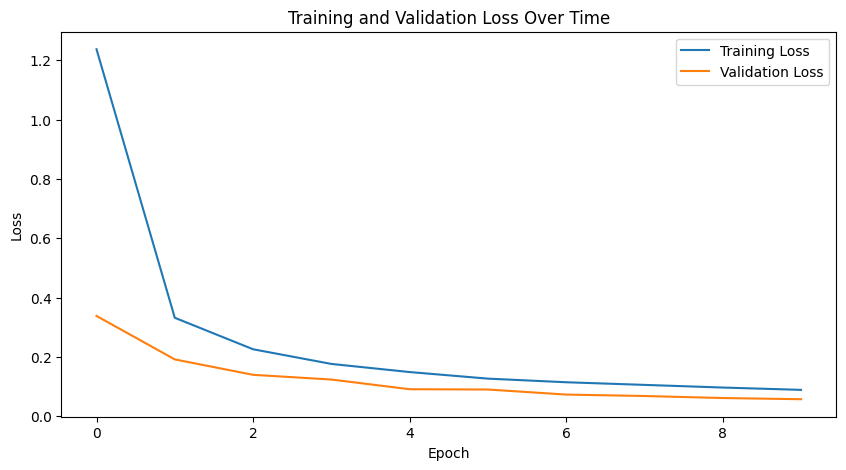

In [5]:
from tqdm import tqdm

# Initialize custom datasets
training_dataset = CustomDataset(training_directory, transform=transform)
testing_dataset = CustomDataset(test_directory, transform=transform)

# data loaders
train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=64, shuffle=True)

# lists for tracking losses
train_losses = []
val_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    net.train()  # Set the model to training mode
    total_train_loss = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

    for images, labels in progress_bar:
        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        
        progress_bar.set_postfix(loss=loss.item())

    # Calculate average training loss for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    net.eval()  # evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# Save the model to .pth
torch.save(net.state_dict(), 'net.pth')